# Keras & TensorFlow CNN Multiclass Classification

## Author
[![Andreja Nesic](https://andrejanesic.com/git-signature-sm.png)](https://andrejanesic.com)

## Download and extract data

Data courtesy of [ETH Zurich.](http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz)

In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Rescaling
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from PIL import Image
import cv2
import math
from tqdm import tqdm
from datetime import datetime
import sys
from time import time

In [2]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.9.2
/device:GPU:0


In [3]:
%mkdir -p input
%cd input

/content/input


In [4]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [5]:
# Download data and extract

get_data_extract()

Dataset already exists


In [6]:
%cd food-101

/content/input/food-101


### Understand dataset structure and files

**The dataset being used is [Food Images (Food-101)](https://www.kaggle.com/datasets/kmader/food41)**
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* **Note found on the webpage of the dataset:** On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [7]:
# Check the extracted dataset folder
!ls

images	license_agreement.txt  meta  README.txt


**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [8]:
# Check that we have all images here
!ls images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [9]:
# Meta files
!ls meta

classes.txt  labels.txt  test.json  test.txt  train.json  train.txt


In [10]:
!head meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [11]:
!head meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


In [12]:
# Return to project root
%cd ../..

/content


### **Visualize random image from each of the 101 classes**

In [13]:
# Visualize the data, showing one image per class from 101 classes
def visualize_images_from(images_dir, figsize=(25,25)):
    foods_sorted = sorted(os.listdir(images_dir))
    food_id = 0
    
    cols = 6 if len(foods_sorted) > 6 else len(foods_sorted)
    rows = int(math.ceil(len(foods_sorted) / 6.0)) if len(foods_sorted) > 6 else 1
    
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    
    for i in range(rows):
        for j in range(cols):
            try:
                food_selected = foods_sorted[food_id] 
                food_id += 1
            except:
                break
            if food_selected == '.DS_Store':
                continue
            food_selected_images = os.listdir(os.path.join(images_dir,food_selected)) # returns the list of all files present in each food category
            food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
            img = plt.imread(os.path.join(images_dir,food_selected, food_selected_random))
            if rows > 1:
                ax[i][j].imshow(img)
                ax[i][j].set_title(food_selected, pad = 10)
            else:
                ax[j].imshow(img)
                ax[j].set_title(food_selected, pad = 10)
    
    plt.setp(ax, xticks=[],yticks=[])
    plt.tight_layout()
    # https://matplotlib.org/users/tight_layout_guide.html

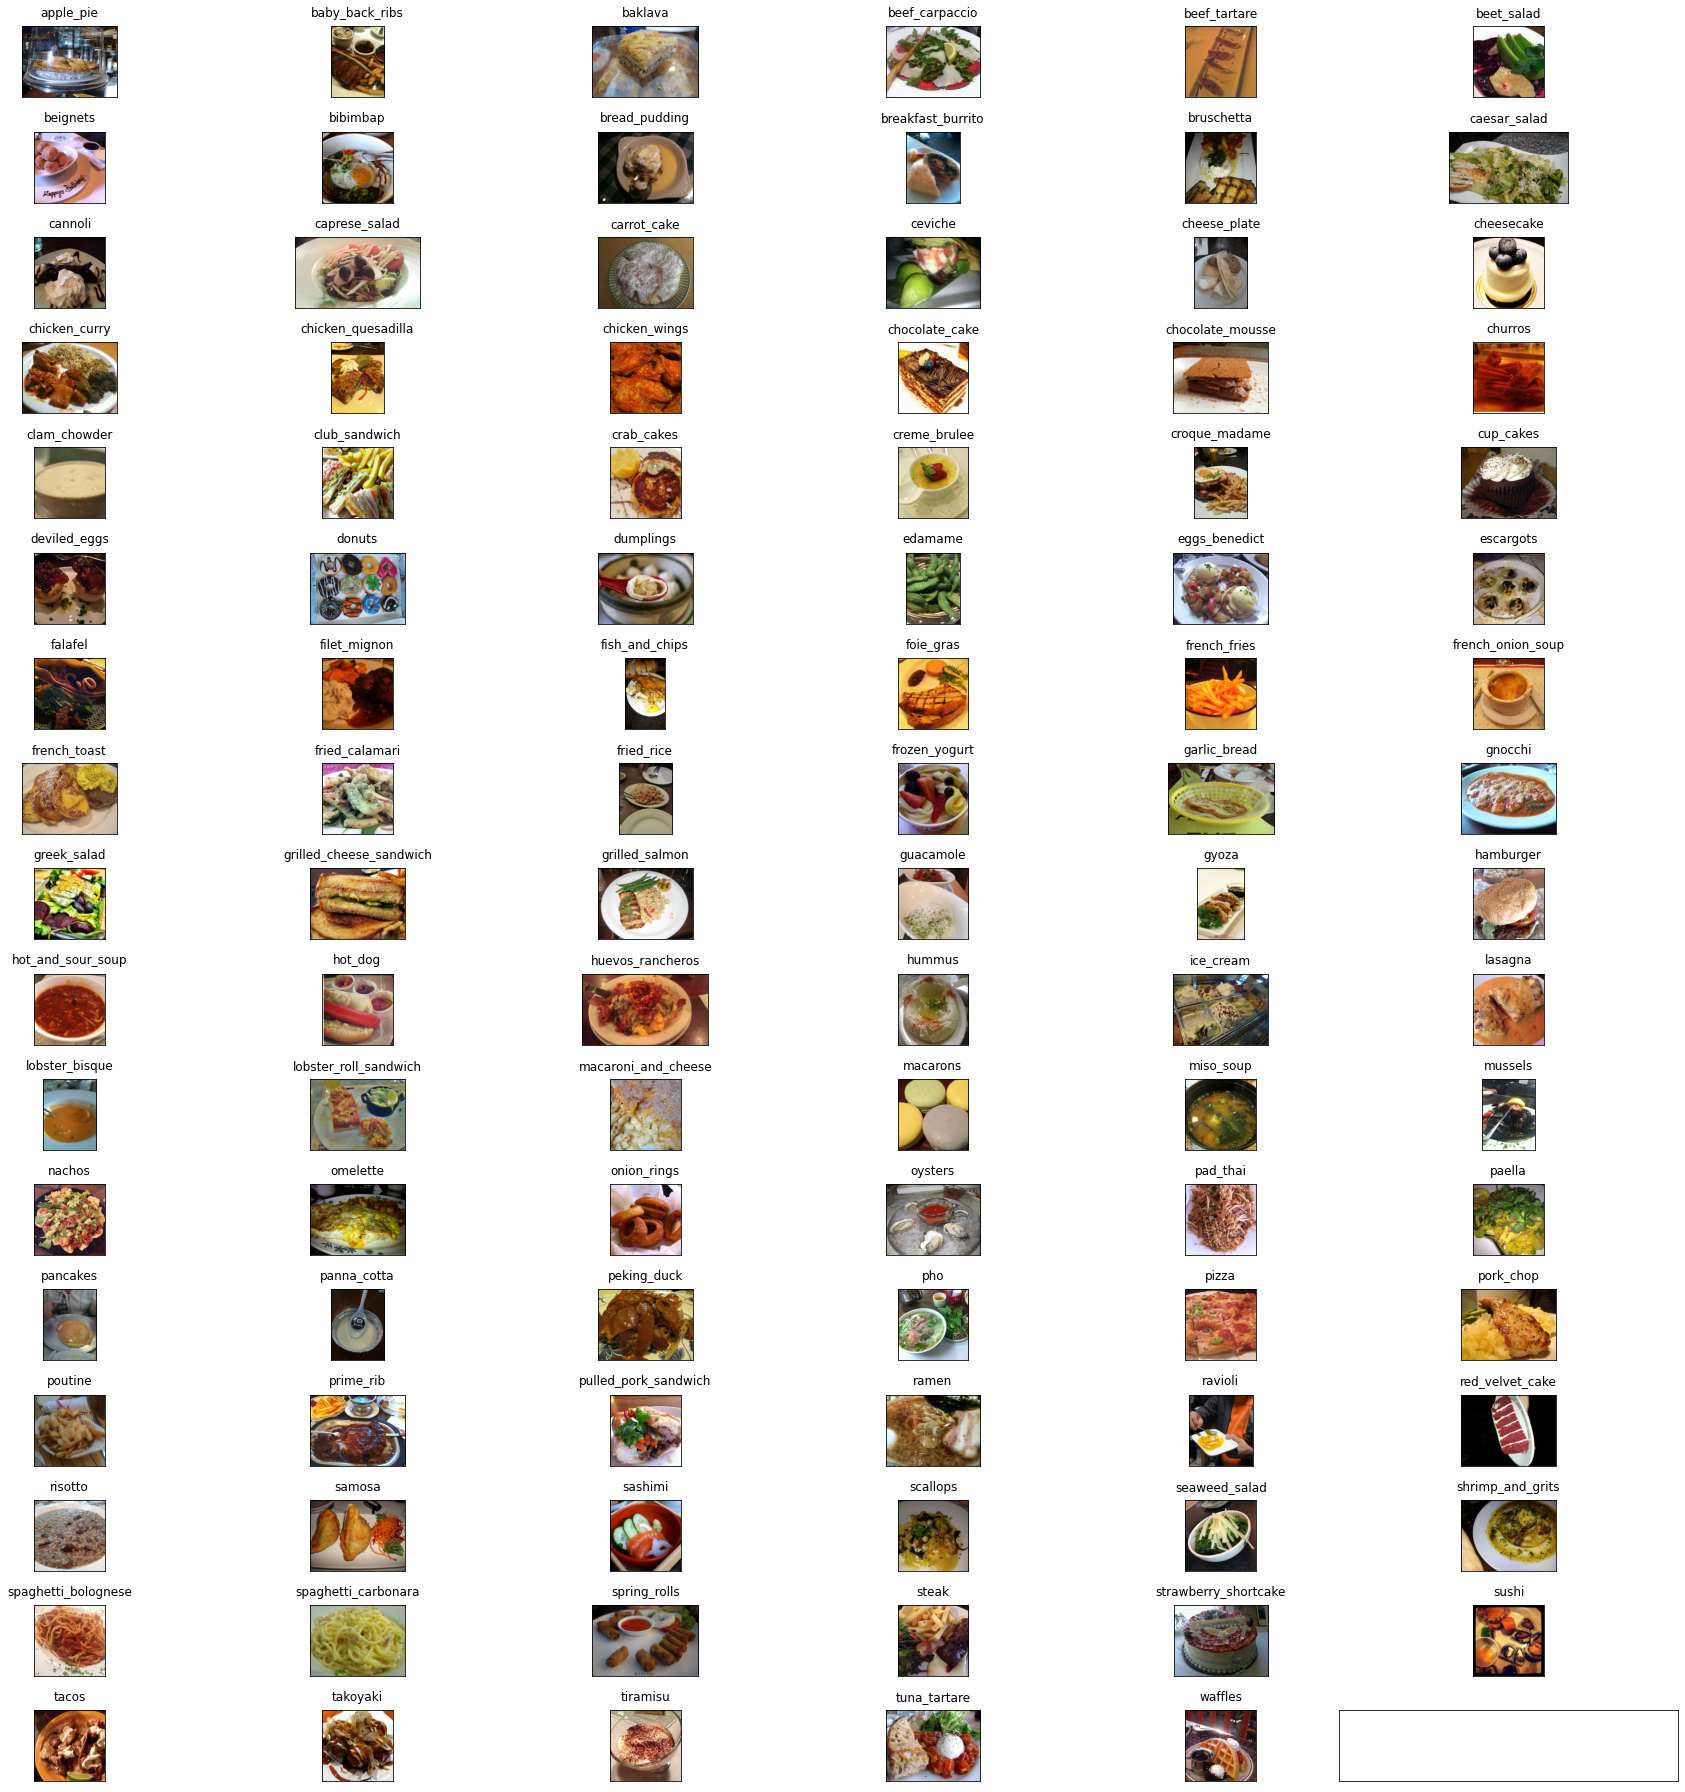

In [14]:
visualize_images_from("input/food-101/images")

### Read train and test data indices

In [15]:
def read_indices(fname):
    indices = {}
    counts = {}
    with open(fname, "r") as f:
        l = f.readline()
        while l:
            cname, val = l.split("/", 1)
            cname = cname.strip()
            val = val.strip()
            if cname not in indices:
                indices[cname] = []
            if cname not in counts:
                counts[cname] = 0
            indices[cname].append(val)
            counts[cname] += 1
            l = f.readline()
    return indices, counts

In [16]:
train_indices, train_indices_counts = read_indices("input/food-101/meta/train.txt")
test_indices, test_indices_counts = read_indices("input/food-101/meta/test.txt")
print(train_indices_counts)
print(test_indices_counts)

{'apple_pie': 750, 'baby_back_ribs': 750, 'baklava': 750, 'beef_carpaccio': 750, 'beef_tartare': 750, 'beet_salad': 750, 'beignets': 750, 'bibimbap': 750, 'bread_pudding': 750, 'breakfast_burrito': 750, 'bruschetta': 750, 'caesar_salad': 750, 'cannoli': 750, 'caprese_salad': 750, 'carrot_cake': 750, 'ceviche': 750, 'cheesecake': 750, 'cheese_plate': 750, 'chicken_curry': 750, 'chicken_quesadilla': 750, 'chicken_wings': 750, 'chocolate_cake': 750, 'chocolate_mousse': 750, 'churros': 750, 'clam_chowder': 750, 'club_sandwich': 750, 'crab_cakes': 750, 'creme_brulee': 750, 'croque_madame': 750, 'cup_cakes': 750, 'deviled_eggs': 750, 'donuts': 750, 'dumplings': 750, 'edamame': 750, 'eggs_benedict': 750, 'escargots': 750, 'falafel': 750, 'filet_mignon': 750, 'fish_and_chips': 750, 'foie_gras': 750, 'french_fries': 750, 'french_onion_soup': 750, 'french_toast': 750, 'fried_calamari': 750, 'fried_rice': 750, 'frozen_yogurt': 750, 'garlic_bread': 750, 'gnocchi': 750, 'greek_salad': 750, 'grilled

## Create a subset of data - train_mini and test_mini for experimenting

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [17]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted = sorted(os.listdir("input/food-101/images"))
if ".DS_Store" in foods_sorted:
    foods_sorted.remove(".DS_Store") # remove .DS_Store from the list

In [18]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [19]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_names, indices_orig):
    mini_indices, mini_indices_counts = {}, {}
    for c in food_names:
        mini_indices[c] = list(indices_orig[c])
        mini_indices_counts[c] = len(indices_orig[c])
    return mini_indices, mini_indices_counts

Picking random classes to test with.

In [20]:
# Random classes to test with
food_list = ["apple_pie", "pizza", "omelette", "hamburger", "ramen", "cannoli", "risotto", "waffles", "hummus", "beet_salad"]

In [21]:
print("Creating indices for limited classes")
mini_train_indices, mini_train_indices_counts = dataset_mini(food_list, train_indices)
mini_test_indices, mini_test_indices_counts = dataset_mini(food_list, test_indices)
print(mini_train_indices_counts)
print(mini_test_indices_counts)

Creating indices for limited classes
{'apple_pie': 750, 'pizza': 750, 'omelette': 750, 'hamburger': 750, 'ramen': 750, 'cannoli': 750, 'risotto': 750, 'waffles': 750, 'hummus': 750, 'beet_salad': 750}
{'apple_pie': 250, 'pizza': 250, 'omelette': 250, 'hamburger': 250, 'ramen': 250, 'cannoli': 250, 'risotto': 250, 'waffles': 250, 'hummus': 250, 'beet_salad': 250}


### Copying input data into individual train and test folders

Preparation for Keras' ImageDataGenerator. Copy train and test images to individual folders.

In [22]:
def prep_data_dir(indices, inpath_base, outpath_base):
    print(f"Copying data into separate folder: {outpath_base}")
    
    for cname, vals in tqdm(indices.items()):
        
        inpath = os.path.join(inpath_base, cname)
        outpath = os.path.join(outpath_base, cname)
    
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        
        for val in vals:
            fname = val + '.jpg'
            fpath_in = os.path.join(inpath, fname)
            fpath_out = os.path.join(outpath, fname)
            if os.path.exists(fpath_out):
                continue
            copy(fpath_in, fpath_out)

In [23]:
train_data_dir = "input/tmp/train_mini"
validation_data_dir = "input/tmp/test_mini"
prep_data_dir(mini_train_indices, "input/food-101/images", train_data_dir)
prep_data_dir(mini_test_indices, "input/food-101/images", validation_data_dir)

Copying data into separate folder: input/tmp/train_mini


100%|██████████| 10/10 [00:00<00:00, 135.47it/s]


Copying data into separate folder: input/tmp/test_mini


100%|██████████| 10/10 [00:00<00:00, 383.05it/s]


Let's examine what we copied.

In [24]:
%ls input/tmp/train_mini
%ls input/tmp/test_mini

apple_pie/   cannoli/    hummus/    pizza/  risotto/
beet_salad/  hamburger/  omelette/  ramen/  waffles/
apple_pie/   cannoli/    hummus/    pizza/  risotto/
beet_salad/  hamburger/  omelette/  ramen/  waffles/


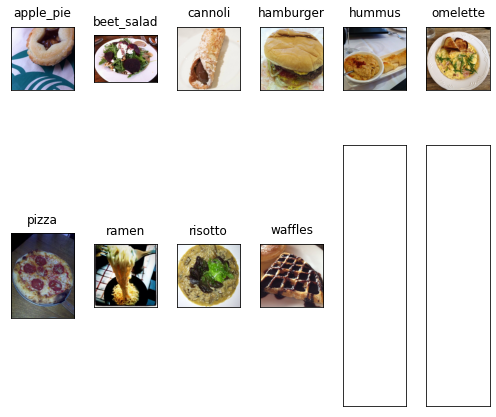

In [25]:
visualize_images_from(train_data_dir, figsize=(7,7))

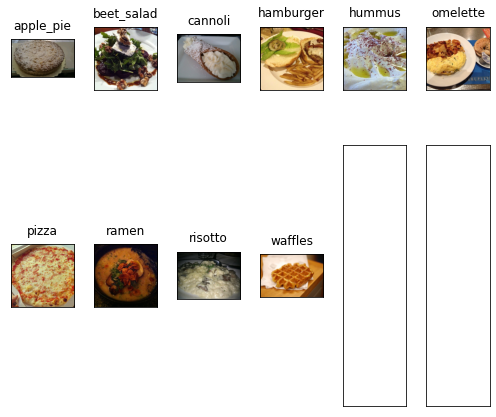

In [26]:
visualize_images_from(validation_data_dir, figsize=(7,7))

If we run `visualize_images_from(train_data_dir)` and `visualize_images_from(train_data_dir)` multiple times, we'll notice that train data sometimes shows mislabelled images. That is okay and is expected as we're working with a large and diverse dataset. What's important is that our test (validation) data is largely showing accurately-labelled images.

## Data Analysis

Let's analyze our dataset. We'll be examining the "mean image" for each class, the differences between classes and the Eigen images from their respective arrays.

In [27]:
%cd input/tmp/

/content/input/tmp


In [28]:
%ls test_mini/apple_pie | head -3
%cd ../..

1011328.jpg
101251.jpg
1034399.jpg
/content


In [29]:
# Our JPG's shape will be w x h x 3 channels [RGB]
np.asarray(Image.open('input/tmp/test_mini/apple_pie/1011328.jpg')).shape

(512, 512, 3)

Let's find the mean image for our selected classes. We'll be using the smallest of all image sizes (downscaling) for this analysis.

In [30]:
# Find smallest image size
def load_images_arrays(image_dir):
    imgs = {}
    for d in os.listdir(image_dir):
        class_dir = os.path.join(image_dir, d)
        if os.path.isfile(class_dir):
            continue
        
        arr = []
        for img in tqdm(os.listdir(class_dir)):
            if img == ".DS_Store":
                continue
            img_path = os.path.join(class_dir, img)
            if not os.path.isfile(img_path):
                continue
            arr.append(np.asarray(Image.open(img_path)))
        
        imgs[d] = arr
    return imgs

In [31]:
analysis_images = load_images_arrays(train_data_dir)

100%|██████████| 750/750 [00:03<00:00, 247.62it/s]


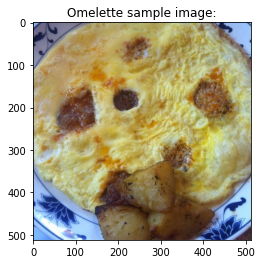

In [32]:
# Sample loaded image
t = list(analysis_images.keys())[random.randint(0, len(list(analysis_images.keys())) - 1)]
plt.title(t.capitalize() + " sample image:")
plt.imshow(analysis_images[t][random.randint(0, len(analysis_images[t]))])

Let's find the smallest resolution image. We'll downscale all images to this resolution for analysis purposes. The actual training will be done with variable-size images being fed through a generator for just-in-time rescaling.

**Reference:** [How to prepare the varied size input in CNN prediction - answer by Amruth Lakkavaram](https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction)

In [33]:
def smallest_res(matrices):
    smallest_shape = (-1, -1, -1)
    smallest_size = sys.maxsize
    
    for m in tqdm(matrices):
        h, w, d = m.shape
        res = h * w
        if res < smallest_size:
            smallest_size = res
            smallest_shape = m.shape
    
    return smallest_shape

In [34]:
# Let's find the smallest-resolution image
smallest_analysis_res = smallest_res([i for v in analysis_images.values() for i in v])
print(smallest_analysis_res)

100%|██████████| 7500/7500 [00:00<00:00, 1297314.42it/s]

(226, 512, 3)


In [35]:
def downscale_res(matrices, new_res):
    for i in tqdm(range(len(matrices))):
        im = Image.fromarray(matrices[i]).resize((new_res[0], new_res[1]))
        matrices[i] = np.asarray(im)
    return matrices

In [36]:
# Downscale all analysis images to the smallest one
analysis_images = {k: downscale_res(analysis_images[k], smallest_analysis_res) for k, v in analysis_images.items()}

100%|██████████| 750/750 [00:02<00:00, 330.58it/s]


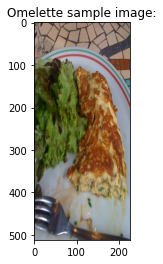

In [37]:
# Sample loaded and downscaled image
t = list(analysis_images.keys())[random.randint(0, len(list(analysis_images.keys())) - 1)]
plt.title(t.capitalize() + " sample image:")
plt.imshow(analysis_images[t][random.randint(0, len(analysis_images[t]))])

In [38]:
# Flatten images for further analysis
analysis_images_flat = {k: np.array([i.ravel() for i in analysis_images[k]]) for k in analysis_images.keys()}
t = list(analysis_images_flat.keys())[random.randint(0, len(list(analysis_images_flat.keys())) - 1)]
print(analysis_images_flat[t])
analysis_images_flat[t][0].shape

[[ 59  46  31 ...  78  59  51]
 [109 111  62 ... 190 202 192]
 [ 86 115  22 ...  66  66  27]
 ...
 [ 23  13  11 ...  46  34  34]
 [246 242 238 ... 251 246 250]
 [  0   0   0 ...  66  39  20]]


(347136,)

Let's calculate the "mean image" for each class and plot it:

In [39]:
def find_mean_img(full_mat, title, size):
    # calculate the average
    print(full_mat.shape)
    mean_img = np.mean(full_mat / 255.0, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    print(mean_img.shape)
    plt.imshow(mean_img, vmin=0, vmax=255)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

(750, 347136)
(512, 226, 3)


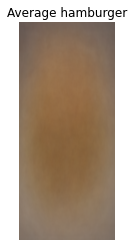

(750, 347136)
(512, 226, 3)


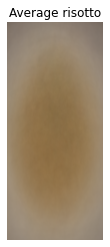

(750, 347136)
(512, 226, 3)


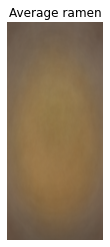

(750, 347136)
(512, 226, 3)


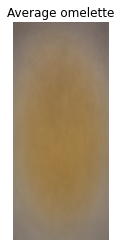

(750, 347136)
(512, 226, 3)


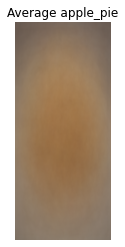

(750, 347136)
(512, 226, 3)


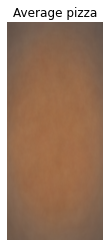

(750, 347136)
(512, 226, 3)


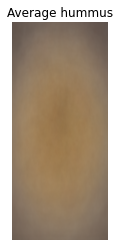

(750, 347136)
(512, 226, 3)


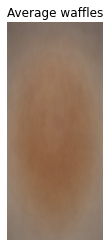

(750, 347136)
(512, 226, 3)


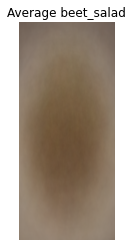

(750, 347136)
(512, 226, 3)


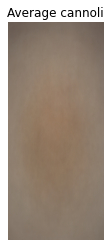

In [40]:
mean_imgs = {}
for k, v in analysis_images_flat.items():
    mean_imgs[k] = find_mean_img(v, k, size=(smallest_analysis_res[1], smallest_analysis_res[0], 3))


Due to the variety of images within classes, it's not possible to discern anything from the median image of each class, except a "median color" (which does not give us any real data). Thus, calculating the differences between median class images would not yield any valuable results. This step is skipped.

_#TODO Eigen images?_

## Training the model

In [41]:
%rm -rf output
%mkdir -p output

In [42]:
def CNN_model(img_height, img_width, num_classes, augment=True):
    model = Sequential()
    
    model.add(Convolution2D(filters=64, kernel_size=(6,6), strides=(1,1), activation='relu', padding='same', input_shape=(img_height, img_width, 3)))
    model.add(Convolution2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Convolution2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Convolution2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Convolution2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters=1024, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(Convolution2D(filters=1024, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
  
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )

    return model

In [43]:
K.clear_session()
n_classes = len(list(mini_train_indices_counts.keys()))
img_height, img_width = 250, 250
nb_train_samples = n_classes * mini_train_indices_counts['apple_pie']
nb_validation_samples = n_classes * mini_test_indices_counts['apple_pie']
batch_size = 16
epochs = 20

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

ts = int(datetime.timestamp(datetime.now()))
checkpointer_fp = f"./output/{ts}-checkpointer.hdf5"
model_fp = f"./output/{ts}-model.hdf5"
logger_fp = f"./output/{ts}-history.log"

model = CNN_model(img_height, img_width, n_classes)
# checkpointer = ModelCheckpoint(filepath=checkpointer_fp, verbose=1, save_best_only=True)
csv_logger = CSVLogger(logger_fp)

start_time = time()
history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[
                        csv_logger,
                        # checkpointer,
                    ])
end_time = time()

model.save(model_fp)


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 197s 393ms/step - loss: 160105.1094 - accuracy: 0.0947 - precision: 0.0851 - recall: 5.3447e-04 - val_loss: 2.3030 - val_accuracy: 0.1002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
468/468 [==============================] - 179s 381ms/step - loss: 2.3039 - accuracy: 0.0951 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3033 - val_accuracy: 0.0998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
468/468 [==============================] - 178s 380ms/step - loss: 2.3113 - accuracy: 0.1025 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3041 - val_accuracy: 0.1002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
468/468 [==============================] - 178s 380ms/step - loss: 2.3043 - accuracy: 0.0981 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3031 - val_accurac

KeyboardInterrupt: ignored

### Evaluation of results

We'll log the training time, validation loss, precision, accuracy and F1 score.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(
    validation_generator,
    verbose=1,
)

In [ ]:
# Visualizing results
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
    
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

In [ ]:
plot_accuracy(history, f"FOOD101-Model-{ts}")
plot_loss(history, f"FOOD101-Model-{ts}")

In [ ]:
def save_results(ts, time_delta, model, loss, accuracy, precision, recall, comment):
  fname = f"output/{ts}-summary.txt"
  with open(fname, "w") as f:
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    f1 = 2.0 * precision * recall / (precision + recall)
    time_delta = time_delta / 60.0
    f.write(short_model_summary)
    f.write(f"\nTraining time (min):{time_delta}")
    f.write(f"\nLoss:{loss}")
    f.write(f"\nAccuracy:{accuracy}")
    f.write(f"\nF1 score:{f1}")
    f.write(f"\nPrecision:{precision}")
    f.write(f"\nRecall:{recall}")
    if comment != None:
      f.write(f"\n{comment}")
    print(f"Model results saved in {fname}")

In [ ]:
save_results(ts, end_time - start_time, model, loss, accuracy, precision, recall, "Changing optimizer to Adam, lr=0.005")

## Notes & Analysis

1. Tried a simple 128x128 CNN with two convolution layers and a dense layer. Accuracy around 40% on only 3 classes. Next, expanded model to include 5 classes. Accuracy decreased.

2. Increased input shape to 200x200, added another layer of Conv2D and lowered dropouts in between. Training accuracy 37%. Down to 10 epochs from previous 30. Probably due to increase in input size.

3. Testing same network as #2 but with sigmoid instead of softmax. Training accuracy around 36%. Thus, softmax is probably better, especially as we're dealing with multiclass classification. Reference: [How to Choose an Activation Function for Deep Learning](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/)

4. Changed number of filters to be lower from one block to the next. Added two more blocks. Model too slow to train + technical error, so aborted.

5. Dropped first block (3 blocks total). Accuracy around 23%. Clearly bad number of filters.

6. Modelled the CNN more like a VGG. Increasing filters from first to last block. Training accuracy seems to be improving at 30%.

7. Increased learning rate by 10x, improved training accuracy at 42%.

8. Increased epochs to 20, input size to 300x300 and altered dense block. Accuracy reaches 50%.

9. \[1668682337\] Tried an alternative optimization method - switched SGD to Adam with learning_rate=0.005. Probably too high LR because accuracy kept varying between around 20% +/-2%. Switched back to SGD model with LR=0.005.

10. \[1668685923\] SGD model reaches around 43% accuracy.

11. \[1668696003\] Added another block with 384 filters, still using SGD with LR=5*10^-3. Accuracy around 38%.

12. \[1668698939\] Hit 43% accuracy with 0.01 LR. Maybe more epochs? Add another block.

13. \[1668701742\] Tested adding another block, increased size of outputs. Got worse results (28%)

14. \[1668977962\] Not the final model because of low accuracy. Expected much higher. Reverting back to 3 blocks and 2x2048 dense.

15. \[1668979758\] Even lower accuracy. Going back to 5 blocks, 4096 dense each. Removing momentum setting.

16. \[1668981859\] Still not improving, changing optimizer to Adam, lr=0.005.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r output /content/drive/MyDrive/andrejanesic-keras-tensorflow-cnn-multiclass-classification